In [51]:
import tensorflow as tf
import tensorflow.keras as tk

from tensorflow.keras.backend import expand_dims, cast
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dropout, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import numpy as np

from imshowtools import imshow

In [52]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = cast(expand_dims(x_train, axis=-1), dtype='float32')
x_test = cast(expand_dims(x_test, axis=-1), dtype='float32')
[x_train.shape, y_train.shape], [x_test.shape, y_test.shape]

([TensorShape([60000, 28, 28, 1]), (60000,)],
 [TensorShape([10000, 28, 28, 1]), (10000,)])

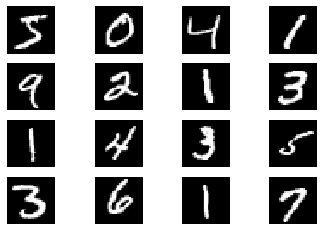

In [53]:
imshow(*x_train[:16, :, :, 0], cmap='gray')

In [54]:
def discriminator():
    input_image = Input(shape=(28, 28, 1), name="image")
    x = Conv2D(64, (3,3), padding="same", strides=(2, 2))(input_image)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)
    x = Conv2D(64, (3,3), padding="same", strides=(2, 2))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=input_image, outputs=x, name="discriminator")
    model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), 
                  loss="binary_crossentropy", 
                  metrics=["accuracy"])
    return model

In [55]:
model_disc = discriminator()
model_disc.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 7, 7, 64)        

In [56]:
def generate_real_samples(dataset, n):
    indices = np.random.randint(0, dataset.shape[0], n)
    x = tf.gather(dataset, indices)
    y = np.ones((n, 1))
    return x, y

In [57]:
def generate_fake_samples(n):
    x = np.random.rand(n, 28, 28, 1)
    y = np.zeros((n, 1))
    return x, y

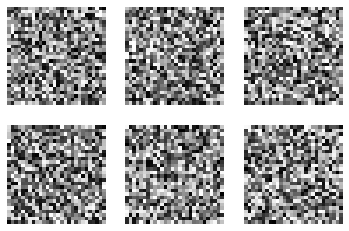

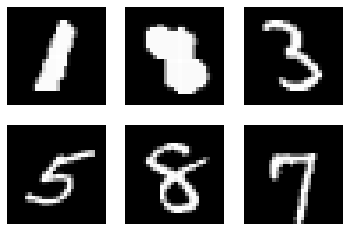

In [58]:
test_fake_samples, _ = generate_fake_samples(6)
imshow(*test_fake_samples[:, :, :, 0], cmap="gray")

test_real_samples, _ = generate_real_samples(x_train, 6)
imshow(*test_real_samples[:, :, :, 0], cmap="gray")

In [59]:
def train_discriminator(model, dataset, batch_size=256):
    x_real, y_real = generate_real_samples(dataset, batch_size)
    x_fake, y_fake = generate_fake_samples(batch_size)
    loss_real, acc_real = model.train_on_batch(x_real, y_real)
    loss_fake, acc_fake = model.train_on_batch(x_fake, y_fake)
    print('{:10.2f} | {:10.2f} | {:10.2f} | {:10.2f}'.format(loss_real, loss_fake, acc_real, acc_fake))

In [60]:
model_disc = discriminator()
print('{:>10s} | {:>10s} | {:>10s} | {:>10s}'.format("loss_real", "loss_fake", "acc_real", "acc_fake"))
for i in range(30):
    train_discriminator(model_disc, x_train, 256)

 loss_real |  loss_fake |   acc_real |   acc_fake
      0.70 |       0.72 |       0.39 |       0.29
      0.69 |       0.70 |       0.50 |       0.38
      0.69 |       0.67 |       0.50 |       0.68
      0.69 |       0.66 |       0.54 |       0.77
      0.69 |       0.64 |       0.53 |       0.88
      0.69 |       0.61 |       0.57 |       0.96
      0.69 |       0.60 |       0.58 |       0.99
      0.68 |       0.58 |       0.66 |       0.99
      0.68 |       0.56 |       0.63 |       1.00
      0.68 |       0.53 |       0.66 |       1.00
      0.67 |       0.51 |       0.70 |       1.00
      0.67 |       0.49 |       0.71 |       1.00
      0.67 |       0.46 |       0.73 |       1.00
      0.66 |       0.44 |       0.78 |       1.00
      0.66 |       0.41 |       0.76 |       1.00
      0.66 |       0.39 |       0.79 |       1.00
      0.64 |       0.36 |       0.86 |       1.00
      0.64 |       0.33 |       0.84 |       1.00
      0.63 |       0.30 |       0.89 |       1.00


In [61]:
latent_dim = 100
def generator():
    input_vector = Input(shape=latent_dim)
    x = Dense(128 * 7 * 7, activation="relu")(input_vector)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((7, 7, 128))(x)
    x = Conv2DTranspose(128, (4,4), strides=(2,2), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2DTranspose(128, (4,4), strides=(2,2), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(1, (7,7), padding="same", activation="sigmoid")(x)
    model = Model(inputs=input_vector, outputs=x, name="generator")
    return model

In [62]:
model_gen = generator()
model_gen.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_21 (Dense)             (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 28, 28, 128)       26

In [63]:
def generate_fake_samples(model: Model, n):
    x_latent_vector = np.random.randn(n, latent_dim)
    x = model.predict(x_latent_vector)
    y = np.zeros((n,1))
    return x, y

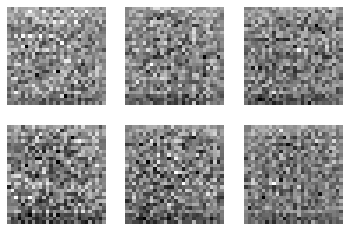

In [64]:
test_fake_samples, _ = generate_fake_samples(model_gen, 6)
imshow(*test_fake_samples[:, :, :, 0], cmap="gray")

In [65]:
def gan(generator: Model, discriminator: Model):
    discriminator.trainable = False
    model = Model(inputs=generator.input, outputs=discriminator(generator.output), name="gan")
    model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), 
                  loss="binary_crossentropy")
    return model

In [66]:
model_gan = gan(model_gen, model_disc)
model_gan.summary()

Model: "gan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_21 (Dense)             (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 28, 28, 128)       262272  

In [67]:
def train_generator(model_gan: Model, batch_size=256):
    x = np.random.randn(batch_size, latent_dim)
    y = np.ones((batch_size, 1))
    loss = model_gan.train_on_batch(x, y)
    print('{:10.2f}'.format(loss))

In [68]:
print('{:>10}'.format("Loss"))
for i in range(10):
    train_generator(model_gan)

      Loss
      2.40
      2.38
      2.34
      2.30
      2.22
      2.16
      2.08
      1.96
      1.79
      1.59


In [73]:
def train_gan(model_disc: Model, model_gen: Model, model_gan: Model, batch_size, epochs):
    # print('{:>10} | {:>10} | {:>10} | {:>10}'.format("Epoch", "Loss Fake", "Loss Real", "Loss Gen"))
    print('{:>10} | {:>10} | {:>10}'.format("Epoch", "Loss Disc", "Loss Gen"))
    step_size = len(x_train) // batch_size
    for i in range(epochs):
        for j in range(step_size):
            x_fake, y_fake = generate_fake_samples(model_gen, batch_size//2)
            x_real, y_real = generate_real_samples(x_train, batch_size//2)
            x = tf.concat([x_fake, x_real], axis=0)
            y = tf.concat([y_fake, y_real], axis=0)
            loss_disc, _ = model_disc.train_on_batch(x, y)
            # loss_fake, acc_fake = model_disc.train_on_batch(x_fake, y_fake)
            # loss_real, acc_real = model_disc.train_on_batch(x_real, y_real)
            
            x_latent_vectors = np.random.randn(batch_size, latent_dim)
            loss_gen = model_gan.train_on_batch(x_latent_vectors, np.ones((batch_size, 1)))
        
        # print('{:10d} | {:10.2f} | {:10.2f} | {:10.2f}'.format(i+1, loss_fake, loss_real, loss_gen))
        print('{:10d} | {:10.2f} | {:10.2f}'.format(i+1, loss_disc, loss_gen))

In [74]:
model_disc = discriminator()
model_gen = generator()
model_gan = gan(model_gen, model_disc)

In [75]:
train_gan(model_disc, model_gen, model_gan, batch_size=256, epochs=10)

     Epoch |  Loss Disc |   Loss Gen
         1 |       0.07 |       2.57
         2 |       0.46 |       0.79
         3 |       0.90 |       0.54
         4 |       0.67 |       0.84
         5 |       0.79 |       0.66
         6 |       0.68 |       0.74
         7 |       0.69 |       0.74
         8 |       0.67 |       0.75
         9 |       0.66 |       0.70
        10 |       0.74 |       0.72


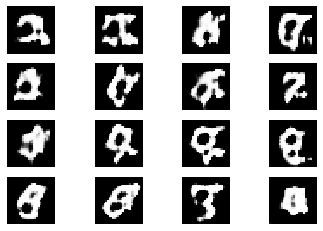

In [87]:
test_fake_samples, _ = generate_fake_samples(model_gen, 16)
imshow(*test_fake_samples[:, :, :, 0], cmap="gray")